In [7]:
import pandas as pd
!pip install psmatching

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
import psmatching.match as psm
import pytest
import pandas as pd
import numpy as np
from psmatching.utilities import *
import statsmodels.api as sm

In [29]:
#no psm
df = pd.read_csv('..\..\..\数据集\因果识别数据集\psm_gxslsj_data.csv')
# df.info()
no_matched_re = df.groupby(['CASE']).agg({'OPTUM_LAB_ID':np.size, 'PUSH':np.mean}).reset_index()
no_matched_re
add_rate = no_matched_re['PUSH'].iloc[1]/no_matched_re['PUSH'].iloc[0] -1
add_rate

1.9888089528377297

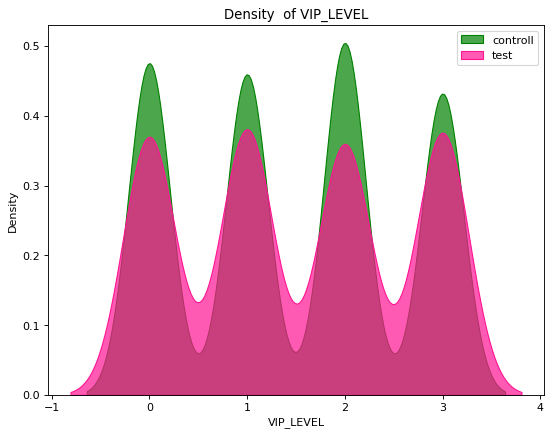

In [33]:
# show the distribution of other features
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.figure(figsize=(8,6), dpi= 80)

#sset shade=True to show full color
sns.kdeplot(df.loc[df['CASE'] == 0, "VIP_LEVEL"], shade=True, color="g", label="controll", alpha=.7)
sns.kdeplot(df.loc[df['CASE'] == 1, "VIP_LEVEL"], shade=True, color="deeppink", label="test", alpha=.7)

# Decoration
plt.title('Density  of VIP_LEVEL', fontsize=12)
plt.legend()
plt.show()

the result shows the distribution of VIP_LEVEL in two group is different

In [ ]:
# so use psm to match now
# attention：set treatment column name: CASE ，id column name: OPTUM_LAB_ID
# set path
path = r'..\..\..\数据集\因果识别数据集\psm_gxslsj_data.csv'
# set model
model = "PUSH ~ AGE + SEX + VIP_LEVEL + LASTDAY_BUY_DIFF + PREFER_TYPE + LOGTIME_PREFER + USE_COUPON_BEFORE + ACTIVE_LEVEL"
# set match 3 example
k = "3"
m = psm.PSMatch(path, model, k)
m.prepare_data()
m.match(caliper=None, replace=True)
matched_data = m.matched_data.reset_index()
matched_data.head()

In [38]:
matched_result = matched_data.groupby(['CASE']).agg({'OPTUM_LAB_ID':np.size, 'PUSH':np.mean}).reset_index()
matched_result
add_rate_adjust = matched_result['PUSH'].iloc[1]/matched_result['PUSH'].iloc[0] -1
add_rate_adjust

,CASE,OPTUM_LAB_ID,PUSH
0,0,2201,0.32667
1,1,1261,1.00000


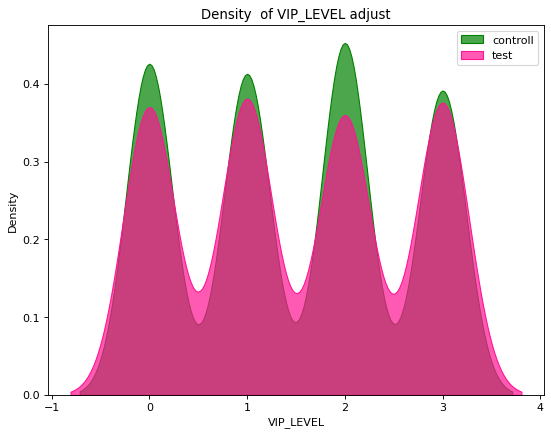

In [39]:
plt.figure(figsize=(8,6), dpi= 80)

#sset shade=True to show full color
sns.kdeplot(matched_data.loc[matched_data['CASE'] == 0, "VIP_LEVEL"], shade=True, color="g", label="controll", alpha=.7)
sns.kdeplot(matched_data.loc[matched_data['CASE'] == 1, "VIP_LEVEL"], shade=True, color="deeppink", label="test", alpha=.7)

# Decoration
plt.title('Density  of VIP_LEVEL adjust', fontsize=12)
plt.legend()
plt.show()

the result show the difference has descrease

In [43]:
# use script to judge the result the psm
### judge the difference by Chi-square test one by one
def var_val(df, treatment):
    #delete meaningless feature
    variables = list(set(df.columns) -set(['Unnamed: 0','OPTUM_LAB_ID','CASE']))
    results = {}
    print("start ...")
    #attention:replace PUSH by treatment
    for var in variables:
        crosstable = pd.crosstab(df[treatment],df[var])
        if len(df[var].unique().tolist()) <= 2:
            # calculate  Chi-square、df 和 p value in 2x2 table
            p_val = calc_chi2_2x2(crosstable)[1]
        else:
            # calculate n*n Chi-square
            p_val = calc_chi2_2xC(crosstable)[1]
        results[var] = p_val
        print("\t" + var + '(' + str(p_val) + ')', end = "")
        if p_val < 0.05:
            print(": No pass") ##3代表
        else:
            print(": PASS")
    if True in [i < 0.05 for i in results.values()]:
        print("\nfeature don't all pass")
    else:
        print("\nfeature all pass")
var_val(matched_data, 'CASE')

start ...
	AGE(0.3883): PASS
	PUSH(0.0): No pass
	LASTDAY_BUY_DIFF(0.3355): PASS
	PROPENSITY(0.4928): PASS
	USE_COUPON_BEFORE(0.0): No pass
	VIP_LEVEL(0.2526): PASS
	SEX(0.0): No pass
	PREFER_TYPE(0.2842): PASS
	ACTIVE_LEVEL(0.2198): PASS
	LOGTIME_PREFER(0.0002): No pass

feature don't all pass
